In [1]:
from python_code.channel.modulator import BPSKModulator
from python_code.channel.channel_estimation import estimate_channel
from python_code.utils.metrics import calculate_error_rates
from python_code.ecc.rs_main import encode
import numpy as np
import torch
import math 

In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [3]:
channel_type = 'ISI_AWGN'
memory_length = 4
noisy_est_var = 0
fading = False
fading_taps_type = 1
channel_coefficients = {'train': 'time_decay', 'val': 'time_decay'}
gamma = 0.2
n_states = 2 ** memory_length
snr = 10
phase = 'val'
block_length = 120
transmission_length = block_length
val_frames = 5
subframes_in_frame = 25
words = val_frames * subframes_in_frame
val_words = words
noise_seed = 3450002
word_seed = 7860002
rand_gen = np.random.RandomState(noise_seed)
word_rand_gen = np.random.RandomState(word_seed)
fading_in_channel = True
fading_in_decoder = True
use_ecc = False
n_symbols = 2

if use_ecc:
    encoding = lambda b: encode(b, n_symbols)
else:
    encoding = lambda b: b

In [4]:
# def estimate_channel(memory_length: int, gamma: float, channel_coefficients: str, noisy_est_var: float = 0,
#                      fading: bool = False, index: int = 0, fading_taps_type: int = 1):
#     """
#     Returns the coefficients vector estimated from channel
#     :param memory_length: memory length of channel
#     :param gamma: coefficient
#     :param channel_coefficients: coefficients type
#     :param noisy_est_var: variance for noisy estimation of coefficients 2nd,3rd,...
#     :param fading: fading flag - if true, apply fading.
#     :param index: time index for the fading functionality
#     :return: the channel coefficients [1,memory_length] numpy array
#     """
#     h = np.array([1, 0.5])
#     return h.reshape(1, memory_length)

In [5]:
random = rand_gen
W_SIGMA = 1

def transmit(c: np.ndarray, h: np.ndarray, snr: float):
    """
    The AWGN Channel
    :param s: to transmit symbol words
    :param snr: signal-to-noise value
    :param random: random words generator
    :param h: channel function
    :param memory_length: length of channel memory
    :return: received word
    """
    if channel_type == 'ISI_AWGN':
        s = BPSKModulator.modulate(c)
        #### ISI AWGN channel ####
        snr_value = 10 ** (snr / 10)
        blockwise_s = np.concatenate([s[:, i:-memory_length + i] for i in range(memory_length)], axis=0)
        conv = np.dot(h[:, ::-1], blockwise_s)
        [row, col] = conv.shape
        w = (snr_value ** (-0.5)) * random.normal(0, W_SIGMA, (row, col))
        y = conv + w

    return y    

In [6]:
#### get_snr_data ####
def get_snr_data(snr: float, gamma: float, database: list):
    if database is None:
        database = []
    b_full = np.empty((0, block_length))
    y_full = np.empty((0, transmission_length))
    if phase == 'val':
        index = 0
    else:
        index = 0  # random.randint(0, 1e6)
    # accumulate words until reaches desired number
    while y_full.shape[0] < words:
        # generate word
        b = word_rand_gen.randint(0, 2, size=(1, block_length))
        # zero padding
        b[:, :memory_length] = 0
        b[:, -1:] = 0
        # encoding - errors correction code
        c = encoding(b).reshape(1, -1)
        # add zero bits
        padded_c = np.concatenate([c, np.zeros([c.shape[0], memory_length])], axis=1)
        # transmit
        h = estimate_channel(memory_length, gamma,
                                channel_coefficients=channel_coefficients[phase],
                                noisy_est_var=noisy_est_var,
                                fading=fading_in_channel if phase == 'val' else fading_in_decoder,
                                index=index,
                                fading_taps_type=fading_taps_type)
        y = transmit(padded_c, h, snr)
        # accumulate
        b_full = np.concatenate((b_full, b), axis=0)
        y_full = np.concatenate((y_full, y), axis=0)
        index += 1

    database.append((b_full, y_full))

In [7]:
from typing import Tuple, List
import concurrent.futures

def get_item(snr_list: List[float], gamma: float) -> Tuple[torch.Tensor, torch.Tensor]:
    database = []
    # do not change max_workers
    with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
        [executor.submit(get_snr_data, snr, gamma, database) for snr in snr_list]
    b, y = (np.concatenate(arrays) for arrays in zip(*database))
    b, y = torch.Tensor(b).to(device=device), torch.Tensor(y).to(device=device)
    return b, y

In [8]:
from python_code.trainers.VA.va_trainer import VATrainer
va_dec = VATrainer()

from python_code.trainers.BCJR.bcjr_trainer import BCJRTrainer
bcjr_dec = BCJRTrainer()

In [9]:
mc_count = 1
snr_list = [snr for snr in range(-10, 12, 2)]
va_ser_list = [0 for _ in range(len(snr_list))]
bcjr_ser_list = [0 for _ in range(len(snr_list))]

for jj in range(len(snr_list)):
    snr = snr_list[jj]
    transmitted_words, received_words = get_item([snr], gamma)

    va_detected_words = va_dec.detector(received_words, 'val', snr, gamma)    
    va_ser, _, _ = calculate_error_rates(va_detected_words, transmitted_words)
    va_ser_list[jj] += va_ser

    bcjr_detected_words = bcjr_dec.detector(received_words, 'val', snr, gamma)
    bcjr_ser, _, err_indices = calculate_error_rates(bcjr_detected_words, transmitted_words)
    bcjr_ser_list[jj] += bcjr_ser
    print(f"SNR = {snr}\t\tVA = {va_ser}\t\tBCJR = {bcjr_ser}")

va_ser_list = [ser / mc_count for ser in va_ser_list]
bcjr_ser_list = [ser / mc_count for ser in bcjr_ser_list]

SNR = -10		VA = 0.3622000217437744		BCJR = 0.35146665573120117
SNR = -8		VA = 0.34380000829696655		BCJR = 0.33213335275650024
SNR = -6		VA = 0.3171333074569702		BCJR = 0.2982666492462158
SNR = -4		VA = 0.2862666845321655		BCJR = 0.26766663789749146
SNR = -2		VA = 0.250333309173584		BCJR = 0.23313331604003906
SNR = 0		VA = 0.2152666449546814		BCJR = 0.19193333387374878
SNR = 2		VA = 0.16406667232513428		BCJR = 0.14773333072662354
SNR = 4		VA = 0.11633330583572388		BCJR = 0.09946668148040771
SNR = 6		VA = 0.06753331422805786		BCJR = 0.04906666278839111
SNR = 8		VA = 0.026600003242492676		BCJR = 0.015266656875610352
SNR = 10		VA = 0.008466660976409912		BCJR = 0.003000020980834961


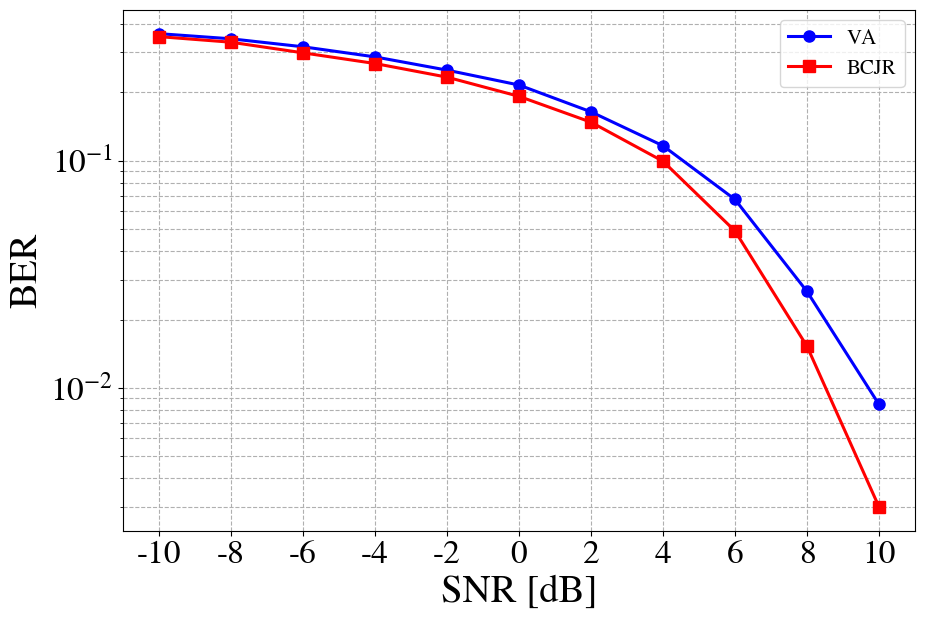

In [10]:
import matplotlib.pyplot as plt

# plt.plot(snr_list, va_ser_list, label='VA')
# plt.plot(snr_list, bcjr_ser_list, label='BCJR')
# plt.legend()
# plt.title('VA vs. BCJR')
# plt.xlabel('SNR')
# plt.ylabel('SER')
# plt.grid()
# plt.show()

plt.plot(snr_list, va_ser_list, label='VA', color='b', marker='o', linestyle='-', linewidth=2.2)
plt.plot(snr_list, bcjr_ser_list, label='BCJR', color='r', marker='s', linestyle='-', linewidth=2.2)
plt.xticks(snr_list, snr_list)
plt.xlabel('SNR [dB]')
plt.ylabel('BER')
plt.grid(which='both', ls='--')
plt.legend(loc='upper right', prop={'size': 15})
plt.yscale('log')
plt.show()

In [11]:
snr = 10
index = 0

# generate word
b = word_rand_gen.randint(0, 2, size=(1, block_length))
# encoding - errors correction code
c = encoding(b).reshape(1, -1)
# add zero bits
padded_c = np.concatenate([c, np.zeros([c.shape[0], memory_length])], axis=1)
# transmit
h = estimate_channel(memory_length, gamma,
                        channel_coefficients=channel_coefficients[phase],
                        noisy_est_var=noisy_est_var,
                        fading=fading_in_channel if phase == 'val' else fading_in_decoder,
                        index=index,
                        fading_taps_type=fading_taps_type)

#### ISI AWGN channel ####
# y = transmit(padded_c, h, snr)
s = BPSKModulator.modulate(padded_c)
snr_value = 10 ** (snr / 10)
blockwise_s = np.concatenate([s[:, i:-memory_length + i] for i in range(memory_length)], axis=0)
conv = np.dot(h[:, ::-1], blockwise_s)
[row, col] = conv.shape
w = (snr_value ** (-0.5)) * random.normal(0, W_SIGMA, (row, col))
y = conv + w

print(f"Shape of Variables")
print(f"b: {b.shape}")
print(f"c: {c.shape}")
print(f"padded_c: {padded_c.shape}")
print(f"h: {h.shape}")
print(f"s: {s.shape}")
print(f"blockwise_s: {blockwise_s.shape}")
print(f"conv: {conv.shape}")
print(f"w: {w.shape}")
print(f"y: {y.shape}")

Shape of Variables
b: (1, 120)
c: (1, 120)
padded_c: (1, 124)
h: (1, 4)
s: (1, 124)
blockwise_s: (4, 120)
conv: (1, 120)
w: (1, 120)
y: (1, 120)


In [12]:
def create_transition_table(n_states: int) -> np.ndarray:
    """
    creates transition table of size [n_states,2]
    previous state of state i and input bit b is the state in cell [i,b]
    """
    transition_table = np.concatenate([np.arange(n_states), np.arange(n_states)]).reshape(n_states, 2)
    return transition_table

In [13]:
#### Viterbi Detector ####
y = received_words

h = np.concatenate([estimate_channel(memory_length, gamma,
    channel_coefficients=channel_coefficients[phase],
    noisy_est_var=noisy_est_var,
    fading=fading_in_channel if phase == 'val' else fading_in_decoder,
    index=index,
    fading_taps_type=fading_taps_type) for index in range(val_words)], axis=0)

all_states_decimal = np.arange(n_states).astype(np.uint8).reshape(-1, 1)
all_states_binary = np.unpackbits(all_states_decimal, axis=1).astype(int)
all_states_symbols = BPSKModulator.modulate(all_states_binary[:, -memory_length:])
state_priors = np.dot(all_states_symbols, h.T)
state_priors = torch.Tensor(state_priors).to(device)

priors = y.unsqueeze(dim=2) - state_priors.T.repeat(
    repeats=[y.shape[0] // state_priors.shape[1], 1]).unsqueeze(
    dim=1)
# to llr representation
priors = priors ** 2 / 2 - math.log(math.sqrt(2 * math.pi))

transition_table_array = create_transition_table(n_states)
transition_table = torch.Tensor(transition_table_array).to(device)

in_prob = torch.zeros([y.shape[0], n_states]).to(device)
decoded_word = torch.zeros(y.shape).to(device)
for i in range(transmission_length):
    # get the lsb of the state
    decoded_word[:, i] = torch.argmin(in_prob, dim=1) % 2
    # run one Viterbi stage (acs block)
    llrs = priors[:, i]
    transition_ind = transition_table.reshape(-1).repeat(in_prob.size(0)).long()
    batches_ind = torch.arange(in_prob.size(0)).repeat_interleave(2 * n_states)
    trellis = (in_prob + llrs)[batches_ind, transition_ind]
    reshaped_trellis = trellis.reshape(-1, n_states, 2)
    out_prob, _ = torch.min(reshaped_trellis, dim=2)
    # update in-probabilities for next layer
    in_prob = out_prob

In [15]:
calculate_error_rates(decoded_word, transmitted_words)

(0.008466660976409912,
 0.3920000195503235,
 tensor([ 10,  15,  16,  17,  20,  23,  24,  25,  26,  27,  28,  29,  30,  31,
          32,  33,  36,  37,  38,  46,  60,  62,  63,  65,  66,  69,  70,  71,
          72,  73,  74,  75,  76,  77,  79,  80,  81,  83,  87,  88,  91,  92,
         117, 118, 119, 120, 121, 123, 124]))